In [1]:
import torch

from matplotlib import pyplot as plt
from pathlib import Path

from lafomo.plot import plot_phase, Colours, tight_kwargs
from lafomo.utilities.torch import inv_softplus, softplus
from lafomo.datasets import DeterministicLotkaVolterra
from experiments.lotka import build_lotka, plot_lotka
from lafomo.configuration import VariationalConfiguration
from lafomo.trainers import VariationalTrainer
import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])


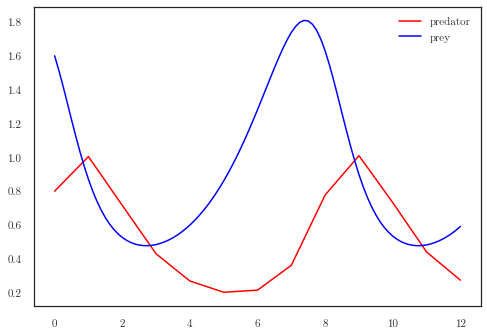

In [2]:
datasets = [DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12,
    fixed_initial=i
) for i in [j*0.8 for j in range(1, 2)]]
dataset = datasets[0]
x_min, x_max = min(dataset.times), max(dataset.times)
plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]

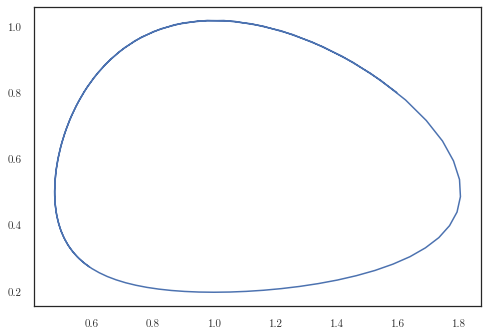

In [3]:
plt.figure()
for dataset in datasets:
    real_prey, real_pred = dataset.prey, dataset.predator
    plt.plot(real_prey, real_pred)
dataset = datasets[0]

In [4]:
params = dict(
    natural=False,
    kernel='periodic'
)
lfm, trainer, plotter = build_lotka(
    dataset, params
    # reload='../../../experiments/lotka/lotka/0savedmodel'
    # reload='./twentyinducing'
)

Num training points:  13
PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


C:\Users\Jacob\Documents\proj\lafomo\lafomo\models\variational_lfm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


In [21]:
params2 = dict(
    natural=False,
    kernel='rbf'
)
lfm2, trainer2, plotter2 = build_lotka(
    dataset, params2
    # reload='../../../experiments/lotka/lotka/0savedmodel'
    # reload='./twentyinducing'
)

Num training points:  13


C:\Users\Jacob\Documents\proj\lafomo\lafomo\models\variational_lfm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


In [31]:
trainer2.train(50, report_interval=10, step_size=5e-1);

Epoch 201/250 - Loss: 0.08 (-0.31 0.38) kernel: [[[1.1825025]]]
Epoch 211/250 - Loss: 0.04 (-0.36 0.41) kernel: [[[1.1869909]]]
Epoch 221/250 - Loss: 0.04 (-0.40 0.45) kernel: [[[1.1868991]]]
Epoch 231/250 - Loss: 0.08 (-0.39 0.47) kernel: [[[1.1870035]]]
Epoch 241/250 - Loss: 0.06 (-0.45 0.51) kernel: [[[1.1893858]]]


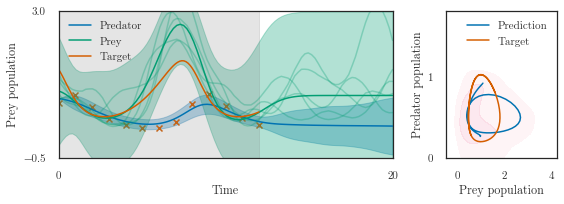

In [36]:
plot_lotka(dataset, lfm2, trainer2, plotter2, Path('./'), params2)
plt.ylim(0, 1.8)
plt.savefig('1.2rbf-combined.pdf')

In [11]:
trainer.train(100, report_interval=10, step_size=5e-1);

Epoch 147/246 - Loss: 0.18 (-0.00 0.18) kernel: [[[0.83921504]]]
Epoch 157/246 - Loss: 0.13 (-0.08 0.21) kernel: [[[0.7803187]]]
Epoch 167/246 - Loss: 0.07 (-0.19 0.26) kernel: [[[0.71829885]]]
Epoch 177/246 - Loss: 0.06 (-0.25 0.30) kernel: [[[0.66558343]]]
Epoch 187/246 - Loss: -0.05 (-0.41 0.36) kernel: [[[0.6318187]]]
Epoch 197/246 - Loss: -0.05 (-0.47 0.42) kernel: [[[0.6114008]]]
Epoch 207/246 - Loss: -0.13 (-0.61 0.47) kernel: [[[0.62699676]]]
Epoch 217/246 - Loss: -0.21 (-0.72 0.51) kernel: [[[0.6571727]]]
Epoch 227/246 - Loss: -0.28 (-0.83 0.55) kernel: [[[0.6824149]]]
Epoch 237/246 - Loss: -0.37 (-0.97 0.60) kernel: [[[0.7162748]]]


tensor([[0.5764]], dtype=torch.float64, grad_fn=<LogBackward>)


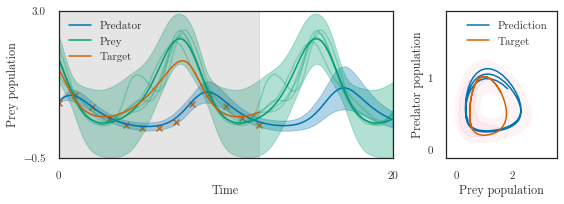

In [12]:
print(lfm.growth_rate)
# plt.style.use('seaborn-white')
plot_lotka(dataset, lfm, trainer, plotter, Path('./'), params)
# plt.savefig('1.2periodic-combined.pdf')
# lfm.save('./twentyinducing')

In [30]:
print(lfm.decay_rate)
with torch.no_grad():
    # lfm.raw_growth+= 0.1
    lfm.raw_decay += 0.1
print(lfm.growth_rate)
print(lfm.gp_model.covar_module.base_kernel.period_length)
print(lfm.gp_model.mean_module.constant)

tensor([[0.6838]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[0.6937]], dtype=torch.float64, grad_fn=<LogBackward>)
tensor([[[8.0405]]], grad_fn=<SoftplusBackward>)
Parameter containing:
tensor([[0.5271]], requires_grad=True)


torch.Size([97])
torch.Size([97])


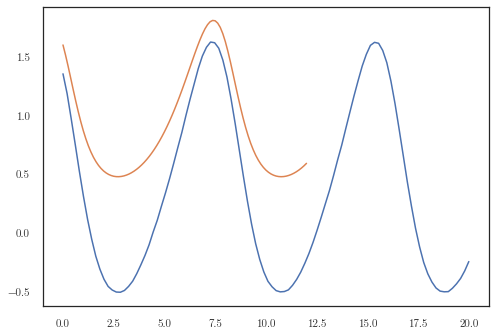

In [21]:
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.mlls import VariationalELBO
lfm.gp_model.train()
gp_model = lfm.gp_model
print(dataset.prey.shape)
print(dataset.times.shape)

likelihood = MultitaskGaussianLikelihood(num_tasks=1)

mll = VariationalELBO(likelihood, gp_model, num_data=dataset.prey.shape[0])
optimizer = torch.optim.Adam([
    {'params': gp_model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

#train gp_model
for i in range(150):
    optimizer.zero_grad()
    output = gp_model(dataset.times)
    loss = -mll(output, inv_softplus(dataset.prey.unsqueeze(-1)))
    loss.backward()
    optimizer.step()

t_interval = (0, 20)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)

q_f = gp_model(t_predict)
samples = q_f.sample(torch.Size([10]))
plt.plot(t_predict, samples.mean(0))
plt.plot(dataset.times, dataset.prey)

tensor([[0.4971]], dtype=torch.float64, grad_fn=<LogBackward>) tensor([[0.5817]], dtype=torch.float64, grad_fn=<AddBackward0>)


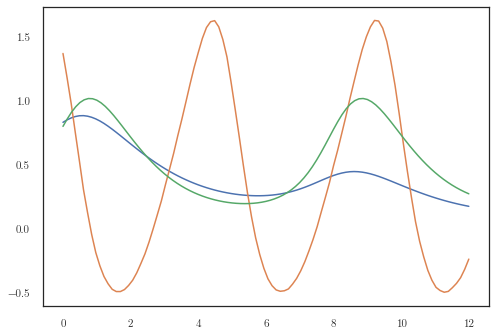

In [13]:
# with torch.no_grad():
#     lfm.raw_growth *= 0
#     lfm.raw_growth += inv_softplus(torch.tensor(1))
#     lfm.raw_decay *= 0
#     lfm.raw_decay += inv_softplus(torch.tensor(1.1))
#     lfm.raw_initial *= 0
#     lfm.raw_initial += inv_softplus(torch.tensor(0.8))
print(lfm.growth_rate, lfm.decay_rate)
gp_model.eval()
lfm.eval()

t_interval = (0, 12)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)
output = lfm(t_predict, step_size=1e-1)


plt.plot(t_predict, output.mean.detach().squeeze())
plt.plot(t_predict, samples.mean(0))
plt.plot(dataset.times, dataset.predator)

In [ ]:
v_targ = dataset.delta * real_prey - dataset.gamma * torch.log(real_prey) + dataset.beta * real_pred - dataset.alpha * torch.log(real_pred)
v_pred = dataset.delta * prey_mean - dataset.gamma * torch.log(prey_mean) + dataset.beta * predator_mean - dataset.alpha * torch.log(predator_mean)

plt.figure()
plt.plot(torch.linspace(0, 12, v_targ.shape[0]), v_targ, label='Target')
plt.plot(t_predict, v_pred, label='Prediction')


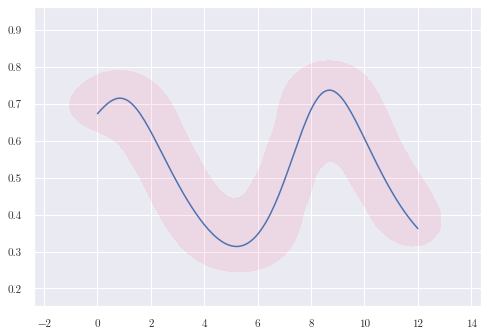

In [39]:
kdeplot(x=t_predict.repeat(50), y=y_samples.flatten(), fill=True, color='pink', alpha=0.1, levels=2, thresh=.1,)
plt.plot(t_predict, predator.mean.detach())